<a href="https://colab.research.google.com/github/vanderbilt-ml/50-shah-mlproj-traffic-accidents/blob/main/TrafficAccidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

#Traffic Accidents

## Background

This is dataset of traffic accidents reported from 2019 to present. The data has been retrieved using manual export and is subject to change during an investigation as more information becomes available.

## Project Description

Each record is a reported traffic accident. Check the metadata field descriptions for more detailed information.

### **Data Dictionary**

Feature	|	Description	|	Type
-------------	|	-------------	|	-------------
AccidentNumber	|	MNPD incident number for the crash	|	Plain Text
AccidentDate	|	Date of the accident	|	Date & Time
Injury	|	Injury reported	|	CheckBox
CollisionType	|	Full text description of the collision type	|	Plain Text
Weather	|	Full text description of the weather conditions	|	Plain Text
Illumination	|	Full text description of the lighting conditions	|	Plain Text
Precinct	|	Assigned precinct in which the accident occurred	|	Plain Text

In [424]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context, tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

## Load Data

Load the traffic accidents data provided using pandas and read it as a dataframe. Please note that the The repository is private so I have to use token to access .csv file.

In [425]:
penguins = pd.read_csv('https://raw.githubusercontent.com/vanderbilt-ml/50-shah-mlproj-traffic-accidents/main/Traffic_Accidents.csv')
display(penguins.head())
penguins.info()

,AccidentNumber,AccidentDate,CollisionType,Weather,Illumination,Precinct,Injury
0,1,6/9/2022,Front,CLEAR,DAYLIGHT,SOUTH,Yes
1,2,6/9/2022,Side Swipe,CLEAR,DAYLIGHT,MIDTOW,No
2,3,6/9/2022,Angle,CLEAR,DAYLIGHT,MIDTOW,No
3,4,6/9/2022,Angle,CLEAR,DAYLIGHT,SOUTH,Yes
4,5,6/9/2022,Angle,CLEAR,DAYLIGHT,HERMIT,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7762 entries, 0 to 7761
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AccidentNumber  7762 non-null   int64 
 1   AccidentDate    7762 non-null   object
 2   CollisionType   7762 non-null   object
 3   Weather         7762 non-null   object
 4   Illumination    7762 non-null   object
 5   Precinct        7762 non-null   object
 6   Injury          7762 non-null   object
dtypes: int64(1), object(6)
memory usage: 424.6+ KB


### Data Cleaning
Detect and Remove Missing values

After exploring and observing the data, there are a few columns with the coded value for which the description is already available. I am removing data values out of the dataframe.

The columns are specified below:

**Date and Time**, **Reporting Officer**, **Collision Type Code**, **Weather Code**, **Illumination Code**, **Harmful Code**, **RPA**

In [426]:
penguins.isnull().sum()

AccidentNumber    0
AccidentDate      0
CollisionType     0
Weather           0
Illumination      0
Precinct          0
Injury            0
dtype: int64

## Feature Engineering

There are many feature engineering techniques including e.g. Imputation, Handling Outliers, Binning, Log Transform, One-Hot Encoding, Grouping Operations, Feature Split, Scaling etc. 

We will be applying lesson learned from various assignments lets create some statistics on the  data attached here. Also create the test and train set, pipeline and check/learn the outcome of the data.

In [427]:
penguins.shape
penguins.head()

,AccidentNumber,AccidentDate,CollisionType,Weather,Illumination,Precinct,Injury
0,1,6/9/2022,Front,CLEAR,DAYLIGHT,SOUTH,Yes
1,2,6/9/2022,Side Swipe,CLEAR,DAYLIGHT,MIDTOW,No
2,3,6/9/2022,Angle,CLEAR,DAYLIGHT,MIDTOW,No
3,4,6/9/2022,Angle,CLEAR,DAYLIGHT,SOUTH,Yes
4,5,6/9/2022,Angle,CLEAR,DAYLIGHT,HERMIT,Yes


**Total Number of accidents based on Collission Type**

In [428]:
penguins["CollisionType"].unique()

array(['Front', 'Side Swipe', 'Angle', 'Other', 'Head On', 'Rear'],
      dtype=object)

In [429]:
collision_types = penguins["CollisionType"].unique()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


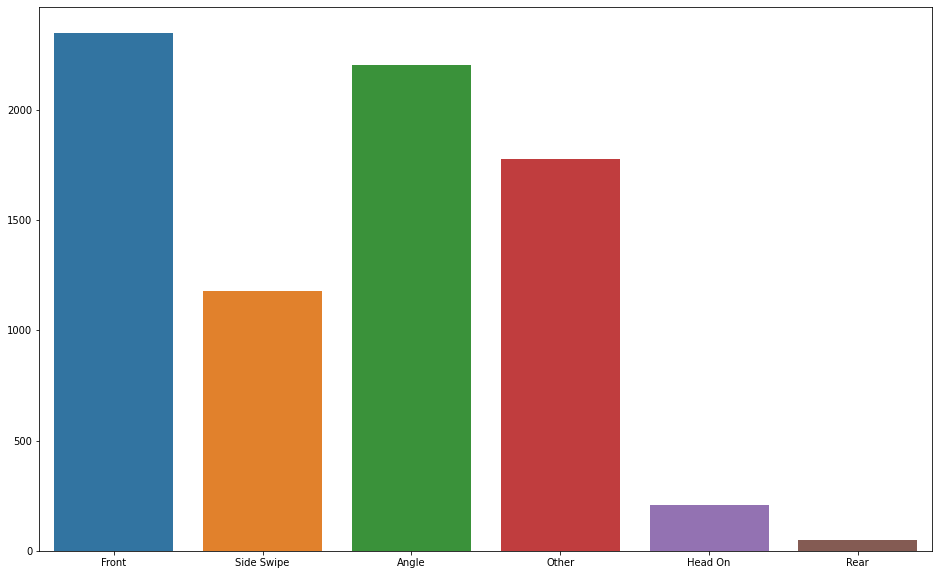

In [430]:
counts_by_collision_type=[]
for i in penguins["CollisionType"].unique(): counts_by_collision_type.append(penguins[penguins['CollisionType']==i].count()['AccidentNumber'])

fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(collision_types, counts_by_collision_type)

**Total Number of accidents based on Weather Condition**

In [431]:
penguins["Weather"].unique()

array(['CLEAR', 'CLOUDY', 'RAIN', 'Other', 'FOG', 'SNOW', 'Sleet', 'Snow'],
      dtype=object)

In [433]:
weather_conditions = penguins["Weather"].unique()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


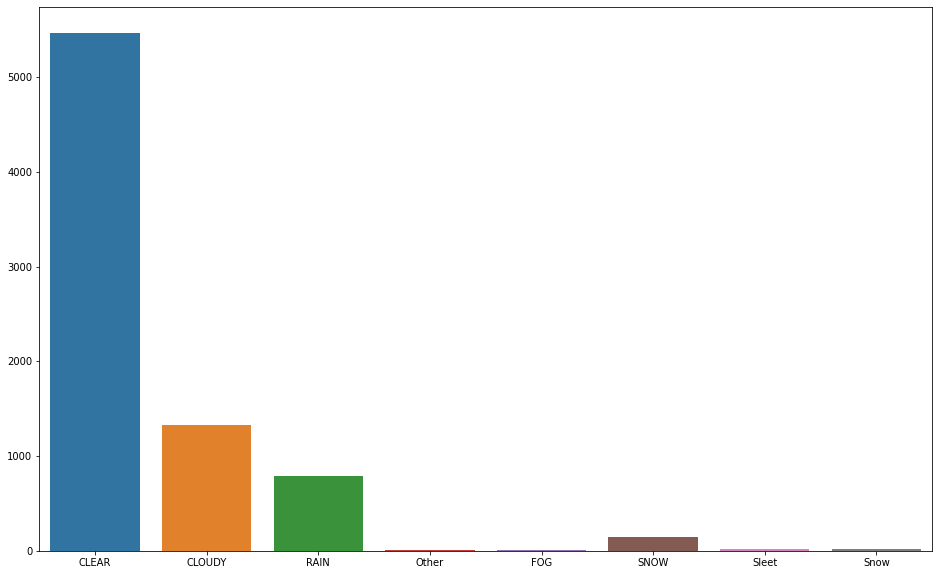

In [434]:
counts_by_weather_condition=[]
for i in penguins["Weather"].unique(): counts_by_weather_condition.append(penguins[penguins['Weather']==i].count()['AccidentNumber'])

fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(weather_conditions, counts_by_weather_condition)

**Total Number of accidents by Day Of Week**

In [435]:
accident_DOW = pd.to_datetime(penguins["AccidentDate"]).dt.day_name().unique()

In [436]:
print(accident_DOW)

['Thursday' 'Wednesday' 'Tuesday' 'Monday' 'Sunday' 'Saturday' 'Friday']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


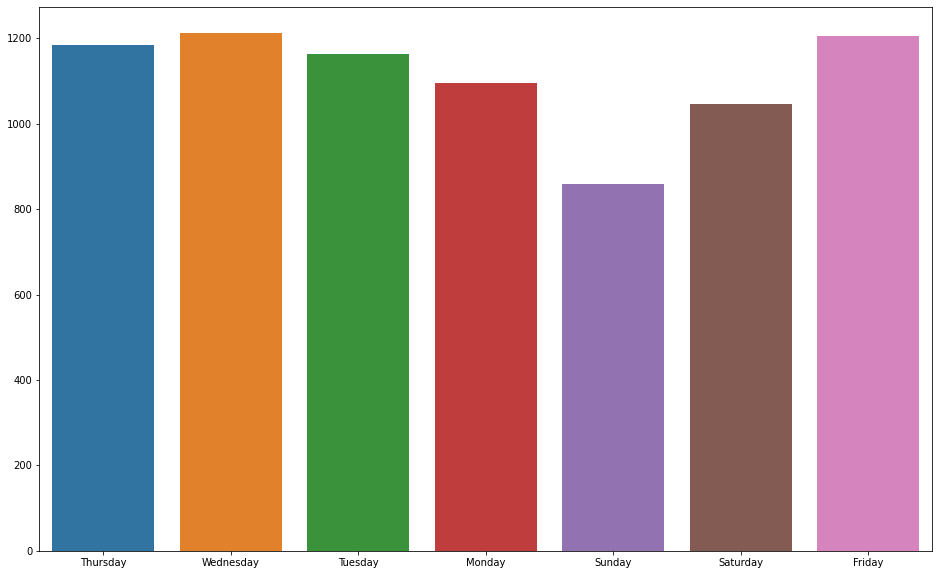

In [437]:
counts_by_DOW=[]
for i in pd.to_datetime(penguins["AccidentDate"]).dt.day_name().unique(): counts_by_DOW.append(penguins[pd.to_datetime(penguins["AccidentDate"]).dt.day_name()==i].count()['AccidentNumber'])

fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(accident_DOW, counts_by_DOW)

In [438]:
penguins = penguins.drop(columns=['AccidentDate'])
penguins.shape
print(penguins.columns)

Index(['AccidentNumber', 'CollisionType', 'Weather', 'Illumination',
       'Precinct', 'Injury'],
      dtype='object')


**Build Test and Train Set**

In [439]:
class_column = 'Injury'
random_seed = 2435

X_train, X_test, Y_train, Y_test = train_test_split(penguins.drop(columns=class_column), penguins[class_column],
                                                   test_size=0.25, random_state=random_seed, stratify=penguins[class_column])

In [440]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (5821, 5)


,AccidentNumber,CollisionType,Weather,Illumination,Precinct
6323,6324,Other,CLEAR,DARK - LIGHTED,WEST
3024,3025,Side Swipe,CLEAR,DAYLIGHT,SOUTH
1009,1010,Front,CLEAR,DAYLIGHT,WEST
2078,2079,Angle,CLEAR,DAYLIGHT,HERMIT
7245,7246,Side Swipe,CLEAR,DARK - LIGHTED,CENTRA



On X test: 
X test dimensions:  (1941, 5)


,AccidentNumber,CollisionType,Weather,Illumination,Precinct
2692,2693,Other,RAIN,DARK - LIGHTED,SOUTH
4371,4372,Other,SNOW,DARK - LIGHTED,WEST
4770,4771,Front,CLEAR,DAYLIGHT,EAST
3091,3092,Front,CLOUDY,DAYLIGHT,SOUTH
3208,3209,Angle,CLOUDY,DAYLIGHT,HERMIT


In [441]:
# Y Train
print('On y train: ')
print('y train dimensions: ', Y_train.shape)
display(Y_train.head())

# Y test
print('\nOn y test: ')
print('y test dimensions: ', Y_test.shape)
display(Y_test.head())

On y train: 
y train dimensions:  (5821,)


6323     No
3024    Yes
1009    Yes
2078     No
7245     No
Name: Injury, dtype: object


On y test: 
y test dimensions:  (1941,)


2692    Yes
4371     No
4770     No
3091    Yes
3208    Yes
Name: Injury, dtype: object

### Training pipeline

Establish the training pipeline for model and repeat several times as needed The pipeline can also change depending on the data types of the columns in the dataset.

In [442]:
#individual pipelines for differing datatypes
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(drop='if_binary'))])
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
                               ('scale_num', StandardScaler())])

In [443]:
#establish preprocessing pipeline by columns
preproc = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')

### Logistic Regression

In [444]:
#generate the whole modeling pipeline with preprocessing
pipe_lg = Pipeline(steps=[('preproc', preproc), ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

#visualization for steps
with config_context(display='diagram'): display(pipe_lg)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc777457e90>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc777457f10>)])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', solver='saga',
                                    tol=0.01))])

### Random Forest Classifier

In [445]:
pipe_rf = Pipeline([('preproc', preproc), ('rf', RandomForestClassifier())])

# Feel free to uncomment and edit the code below to visualize your overall pipeline
with config_context(display='diagram'): display(pipe_rf)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc777457e90>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc777457f10>)])),
                ('rf', RandomForestClassifier())])

### Gradient Boosting Classifier

In [446]:
pipe_gb = Pipeline(steps=[('preproc', preproc), ('gbc', GradientBoostingClassifier())])


# Feel free to uncomment and edit the code below to visualize your overall pipeline
with config_context(display='diagram'): display(pipe_gb)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc777457e90>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc777457f10>)])),
                ('gbc', GradientBoostingClassifier())])

## Cross-validation with hyperparameter tuning

Now that we have our pipelines, we can now use this as part of cross validation and hyperparameter tuning.

### Logistic Regression

In [447]:
tuning_grid_lg = {'mdl__l1_ratio' : np.linspace(0,1,5),
               'mdl__C': np.logspace(-1, 6, 3) }
grid_search_lg = GridSearchCV(pipe_lg, param_grid = tuning_grid_lg, cv = 5, return_train_score=True)

In [448]:
tuning_grid_lg

{'mdl__C': array([1.00000000e-01, 3.16227766e+02, 1.00000000e+06]),
 'mdl__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ])}

In [449]:
grid_search_lg.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc777457e90>),
                                                                        ('num_pipe',
                                                    

In [450]:
print(grid_search_lg.best_score_)
grid_search_lg.best_params_

0.6414701414391694


{'mdl__C': 316.22776601683796, 'mdl__l1_ratio': 0.0}

In [451]:
pd.DataFrame(grid_search_lg.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mdl__C,param_mdl__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.039191,0.003021,0.009866,0.000503,0.1,0.0,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.0}",0.643777,0.635739,0.642612,...,0.641126,0.003540,11,0.641538,0.644192,0.641615,0.641185,0.642044,0.642115,0.001074
1,0.043946,0.002181,0.009650,0.000296,0.1,0.25,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.25}",0.642918,0.634021,0.644330,...,0.640611,0.004156,14,0.641538,0.642903,0.641615,0.641185,0.641400,0.641728,0.000605
2,0.046900,0.007474,0.010181,0.000654,0.1,0.5,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.5}",0.642060,0.635739,0.643471,...,0.640611,0.003400,13,0.641323,0.642044,0.640756,0.641185,0.640112,0.641084,0.000639
3,0.040942,0.001518,0.009374,0.000219,0.1,0.75,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.75}",0.640343,0.635739,0.643471,...,0.640612,0.003412,12,0.640464,0.642259,0.640326,0.641185,0.639253,0.640697,0.000996
4,0.039771,0.001675,0.009997,0.000926,0.1,1.0,"{'mdl__C': 0.1, 'mdl__l1_ratio': 1.0}",0.639485,0.635739,0.642612,...,0.639753,0.002948,15,0.640034,0.642044,0.639253,0.640971,0.639467,0.640354,0.001033
5,0.048459,0.002937,0.009715,0.000119,316.227766,0.0,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.643777,0.636598,0.646907,...,0.641470,0.003542,1,0.641323,0.643762,0.641830,0.642903,0.642903,0.642544,0.000865
6,0.076654,0.005976,0.009745,0.000152,316.227766,0.25,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.643777,0.636598,0.646907,...,0.641470,0.003542,1,0.641323,0.643762,0.641830,0.642903,0.642903,0.642544,0.000865
7,0.078306,0.003331,0.009837,0.000072,316.227766,0.5,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.643777,0.636598,0.646907,...,0.641470,0.003542,1,0.641323,0.643762,0.641830,0.642903,0.642903,0.642544,0.000865
8,0.077082,0.004277,0.010214,0.000435,316.227766,0.75,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.643777,0.636598,0.646907,...,0.641470,0.003542,1,0.641323,0.643762,0.641830,0.642903,0.642903,0.642544,0.000865
9,0.073862,0.001854,0.010064,0.000359,316.227766,1.0,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.643777,0.636598,0.646907,...,0.641470,0.003542,1,0.641323,0.643762,0.641830,0.642903,0.642903,0.642544,0.000865


### Random Forest Classifier

In [452]:
tuning_grid_rf = param_grid = {'rf__n_estimators': [10, 50],
                                        'rf__max_features': ['auto', 'sqrt', 'log2'],
                                        'rf__max_depth' : [4,5,6],
                                        'rf__criterion' :['gini', 'entropy']
                                       }
grid_search_rf = GridSearchCV(pipe_rf, param_grid = tuning_grid_rf, cv = 5, return_train_score=True)

In [453]:
grid_search_rf.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc777457e90>),
                                                                        ('num_pipe',
                                                    

In [454]:
pipe_rf.fit(X_train, Y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc777457e90>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

In [455]:
grid_search_rf.best_params_

{'rf__criterion': 'gini',
 'rf__max_depth': 5,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 10}

In [456]:
print(grid_search_rf.best_score_)

0.6400960134507322


### Gradient Boosting Classifier

In [457]:
tuning_grid_gb = param_grid = {'gbc__learning_rate': [1, 0.5, 0.25],
                                       'gbc__n_estimators': [64, 128, 256],
                                       'gbc__max_depth': [2, 4],
                                       'gbc__min_samples_split': [2, 4]
                                      }
grid_search_gb = GridSearchCV(pipe_gb, param_grid = tuning_grid_gb, cv = 5, return_train_score=True)

In [458]:
grid_search_gb.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc777457e90>),
                                                                        ('num_pipe',
                                                    

In [459]:
pipe_gb.fit(X_train, Y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc777457e90>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

In [460]:
grid_search_gb.best_params_

{'gbc__learning_rate': 0.25,
 'gbc__max_depth': 2,
 'gbc__min_samples_split': 4,
 'gbc__n_estimators': 64}

In [461]:
print(grid_search_gb.best_score_)

0.6363155022639116


## Final fit

The final fit here is already present in the generated model due to the way we set our parameters in the grid search. If we want to look at the performance, we can do so. Here is a non-helpful description of the best model:

### Logistic Regression

In [462]:
grid_search_lg.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc779542410>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

### Random Forest Classifier

In [463]:
grid_search_rf.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7774b1610>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

### Gradient Boosting Classifier

In [464]:
grid_search_gb.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc7773e5650>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

## Variable importance

Now we assess the importance in the selected model to reveal any potential insights.

### Logistic Regression

In [465]:
grid_search_lg.classes_

array(['No', 'Yes'], dtype=object)

In [466]:
vip_lg = grid_search_lg.best_estimator_['mdl'].coef_[0]
vip_lg

array([-0.08785207, -0.14726032,  0.71311065, -0.04866459, -1.10179517,
       -1.1788266 ,  0.08180265,  0.04157444,  0.45605404,  0.89354979,
        0.0649121 ,  0.16671692, -0.14347394, -3.4124241 , -0.10214499,
       -0.14725478,  0.58678179, -0.12772382, -0.50958244, -1.13831875,
       -0.41304511, -0.71047246, -0.30814923, -0.41926773, -0.19124219,
       -0.15717505, -0.2256201 , -0.18504107,  0.77192919, -0.42624946,
       -0.07328227])

In [467]:
#get names in correct preproc order
cat_names = grid_search_lg.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names_out()
cat_names

array(['x0_Angle', 'x0_Front', 'x0_Head On', 'x0_Other', 'x0_Rear',
       'x0_Side Swipe', 'x1_CLEAR', 'x1_CLOUDY', 'x1_FOG', 'x1_Other',
       'x1_RAIN', 'x1_SNOW', 'x1_Sleet', 'x1_Snow', 'x2_DARK - LIGHTED',
       'x2_DARK - NOT LIGHTED', 'x2_DAWN', 'x2_DAYLIGHT', 'x2_DUSK',
       'x2_Dark-Unknown Lighting', 'x2_OTHER', 'x3_CENTRA', 'x3_EAST',
       'x3_HERMIT', 'x3_MADISO', 'x3_MIDTOW', 'x3_NORTH', 'x3_SOUTH',
       'x3_Unknown', 'x3_WEST'], dtype=object)

In [468]:
num_names = grid_search_lg.best_estimator_.named_steps['preproc'].transformers_[1][2]
num_names

['AccidentNumber']

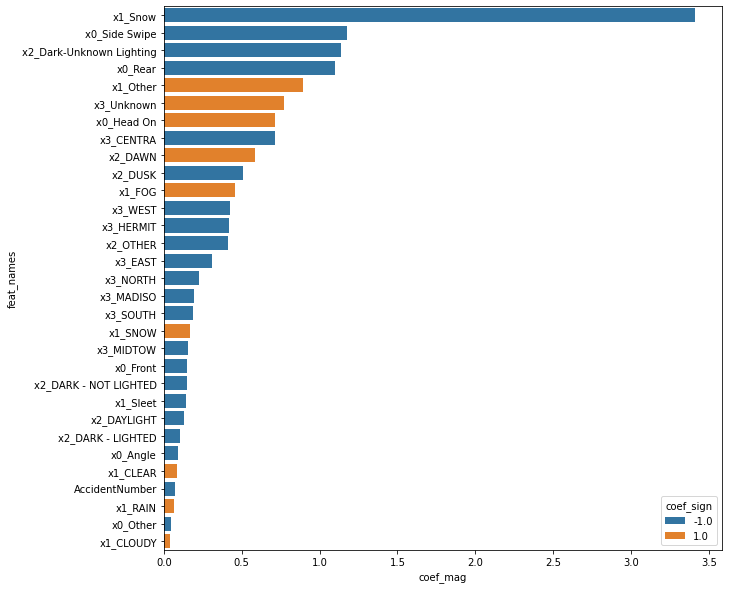

In [469]:
#create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip_lg})

#get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             coef_sign = np.sign(coef_info['vip']))

#sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
plt.figure(figsize=(10, 10)) 
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False);

### Random Forest Classifier

In [470]:
grid_search_rf.classes_

array(['No', 'Yes'], dtype=object)

In [471]:
vip_rf = grid_search_rf.best_estimator_['rf']
vip_rf

RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=10)

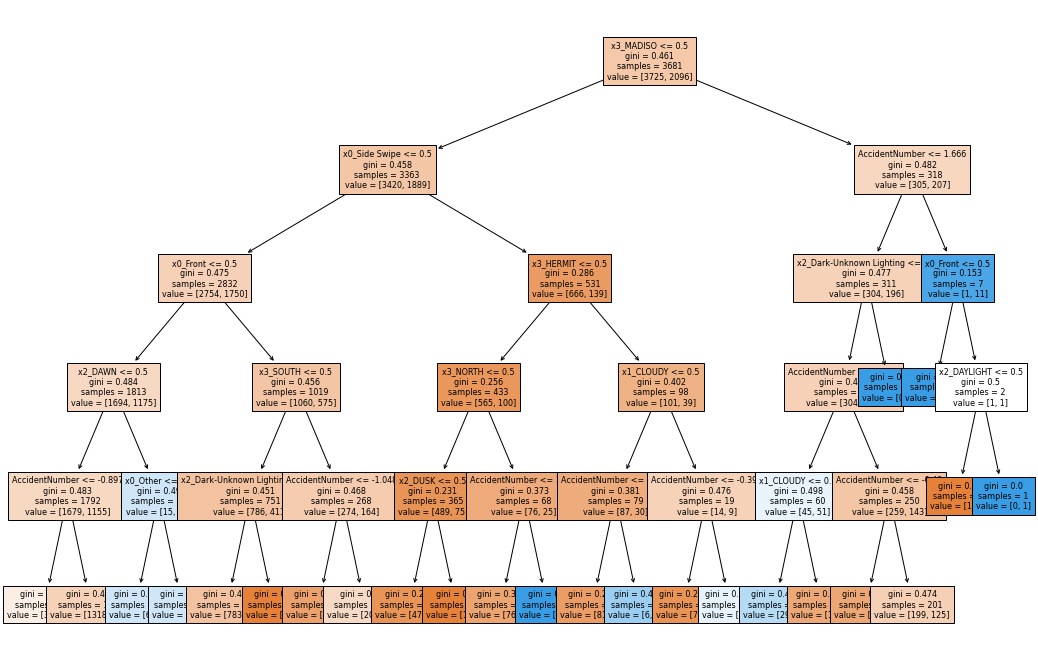

In [472]:
cat_names = grid_search_rf.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names_out()
num_names = grid_search_rf.best_estimator_.named_steps['preproc'].transformers_[1][2]
vip_rf = grid_search_rf.best_estimator_.steps[1]
vip_rf = vip_rf[1].estimators_

plt.figure(figsize=(18, 12)) 
tree.plot_tree(vip_rf[0], feature_names=np.hstack([cat_names, num_names]), fontsize=8, filled=True)
plt.show()

### Gradient Boosting Classifier

In [473]:
grid_search_gb.classes_

array(['No', 'Yes'], dtype=object)

In [474]:
vip_gb = grid_search_gb.best_estimator_['gbc']
vip_gb

GradientBoostingClassifier(learning_rate=0.25, max_depth=2, min_samples_split=4,
                           n_estimators=64)

## Performance metrics on test data

Here, we can see the performance of the model, which is pretty nice! We can also look into different scores specifically for more insight into the performance.

### Logistic Regression

In [475]:
print(classification_report(Y_test, grid_search_lg.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

          No       0.64      0.97      0.77      1233
         Yes       0.54      0.05      0.10       708

    accuracy                           0.64      1941
   macro avg       0.59      0.51      0.44      1941
weighted avg       0.61      0.64      0.53      1941



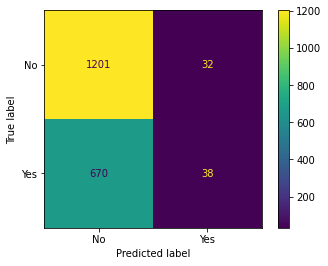

In [476]:
cm_lg = confusion_matrix(Y_test, grid_search_lg.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lg,
                               display_labels=grid_search_lg.classes_)
disp.plot()
plt.show()

### Random Forest Classifier

In [479]:
print(classification_report(Y_test, grid_search_rf.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

          No       0.64      0.99      0.78      1233
         Yes       0.58      0.02      0.03       708

    accuracy                           0.64      1941
   macro avg       0.61      0.50      0.40      1941
weighted avg       0.62      0.64      0.50      1941



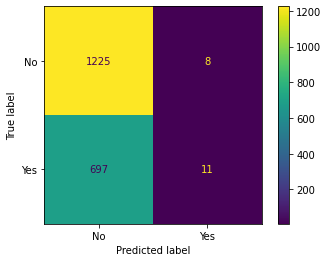

In [480]:
cm_rf = confusion_matrix(Y_test, grid_search_rf.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=grid_search_rf.classes_)
disp.plot()
plt.show()

### Gradient Boosting Classifier

In [481]:
print(classification_report(Y_test, grid_search_gb.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

          No       0.64      0.97      0.77      1233
         Yes       0.48      0.06      0.10       708

    accuracy                           0.63      1941
   macro avg       0.56      0.51      0.44      1941
weighted avg       0.58      0.63      0.53      1941



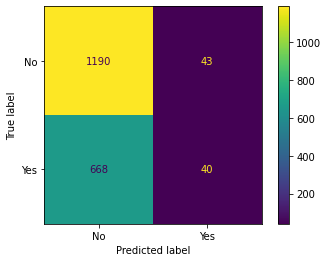

In [482]:
cm_gb = confusion_matrix(Y_test, grid_search_gb.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=grid_search_gb.classes_)
disp.plot()
plt.show()

## Model Comparsion

The comparsion of three model shows that **GRADIENT BOOSTING** model was the best with better accuracy, precision, and f-score

In [484]:
#------------------------------------------------------
# The comparsion of three model shows that GRADIENT BOOSTING classification model was the best
# with higher accuracy, precision, f-score and under the ROC curve.
#------------------------------------------------------
print(classification_report(Y_test, grid_search_lg.best_estimator_.predict(X_test)))
print(classification_report(Y_test, grid_search_rf.best_estimator_.predict(X_test)))
print(classification_report(Y_test, grid_search_gb.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

          No       0.64      0.97      0.77      1233
         Yes       0.54      0.05      0.10       708

    accuracy                           0.64      1941
   macro avg       0.59      0.51      0.44      1941
weighted avg       0.61      0.64      0.53      1941

              precision    recall  f1-score   support

          No       0.64      0.99      0.78      1233
         Yes       0.58      0.02      0.03       708

    accuracy                           0.64      1941
   macro avg       0.61      0.50      0.40      1941
weighted avg       0.62      0.64      0.50      1941

              precision    recall  f1-score   support

          No       0.64      0.97      0.77      1233
         Yes       0.48      0.06      0.10       708

    accuracy                           0.63      1941
   macro avg       0.56      0.51      0.44      1941
weighted avg       0.58      0.63      0.53      1941

